In [35]:
# Personal config
from IPython.core.display import display, HTML
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import teradatasql as sqlt
from sklearn.utils import resample

In [2]:
#test connection avec teradatasql
con = sqlt.connect(None,host='teradata.aws.dmpa.myengie.com', user='AMD_SAS_00_DGP_PROD', password='w6Y.a8[M') 

In [3]:
query = """ 
    SELECT ID_PERS, ID_LOCL, OFFRE, CODE_TYPE_COMPTAGE, CODE_STATUT_OCCUP, CODE_TYPE_HABITAT,NVO_EMMENAG,MT_TOTL_FACT_12M,FL_SERN_CHDR, DATE_REF
    FROM AMD_V_DTMT_DTMN_DGP_PROD.VUE_CLIENTS_ACTIFS AS A 

    WHERE A.DATE_REF = '2021-07-01' 
      
        """

df_raw = pd.read_sql(query,con)

In [4]:
query = """ 
    SELECT ID_PERS, ID_LOCL, date_resil_tot
    FROM AMD_ZAP_PCC_DGP_PROD.RESIL_TOT_DEPUIS_2015 AS B  
    WHERE motif_resil_tot ='CHF' and date_resil_tot >='2021-07-01'
        """

df_pertes = pd.read_sql(query,con)

In [5]:
df_raw = pd.merge(df_raw,
                 df_pertes,
                 right_on=["ID_PERS","ID_LOCL"],
                 left_on=["ID_PERS","ID_LOCL"],
                 how='left')

In [6]:
df_raw['TARGET'] = np.where((df_raw['date_resil_tot'].isnull()), 0, 1)

In [7]:
df_raw['TARGET'].value_counts()/len(df_raw['TARGET'])

0    0.981916
1    0.018084
Name: TARGET, dtype: float64

In [8]:
print( f"Number of Features : {len(df_raw.columns)-1} \n{list(df_raw.columns)}")

Number of Features : 11 
['ID_PERS', 'ID_LOCL', 'OFFRE', 'CODE_TYPE_COMPTAGE', 'CODE_STATUT_OCCUP', 'CODE_TYPE_HABITAT', 'NVO_EMMENAG', 'MT_TOTL_FACT_12M', 'FL_SERN_CHDR', 'DATE_REF', 'date_resil_tot', 'TARGET']


In [9]:
NUMBER_RECORDS = len(df_raw)
print(NUMBER_RECORDS)

5772160


In [10]:
pd.DataFrame([df_raw.dtypes, round(df_raw.isnull().sum()*100 / NUMBER_RECORDS,2)])

,ID_PERS,ID_LOCL,OFFRE,CODE_TYPE_COMPTAGE,CODE_STATUT_OCCUP,CODE_TYPE_HABITAT,NVO_EMMENAG,MT_TOTL_FACT_12M,FL_SERN_CHDR,DATE_REF,date_resil_tot,TARGET
0,float64,float64,object,object,object,object,int64,float64,int64,object,object,int64
1,0.0,0.0,0.0,20.13,0.0,10.86,0.0,20.86,0.0,0.0,98.19,0.0


In [11]:
IDs_fields = [col for col in df_raw.columns if 'ID_' in col]
others_tech_fields = ['DATE_REF']

tech_fields = IDs_fields + others_tech_fields
print(f"Tech Features Removed : {tech_fields}")

Tech Features Removed : ['ID_PERS', 'ID_LOCL', 'DATE_REF']


In [12]:
df_raw = df_raw.drop(tech_fields, axis=1)

In [13]:
SPARSE_THRESHOLD = 0.60
sparse_feats = [col for col in df_raw.columns if df_raw[col].isnull().sum() / NUMBER_RECORDS > SPARSE_THRESHOLD]
sparse_feats

['date_resil_tot']

In [14]:
df_raw = df_raw.drop(sparse_feats, axis=1)

In [15]:
num_features = [feat for feat in df_raw.columns if any(x in feat for x in ['VA_','NB_','MT_'])]
num_features.sort()
print(f"Number of Numerical Features Features : {len(num_features)}")
num_features

Number of Numerical Features Features : 1


['MT_TOTL_FACT_12M']

In [16]:
fl_features = [feat for feat in df_raw.columns if 'FL_' in feat]
lb_features = [feat for feat in df_raw.columns if 'LB_' in feat]
cd_features = [feat for feat in df_raw.columns if 'CODE_' in feat]
fl_features.sort()
lb_features.sort()
cd_features.sort()

In [17]:
print(f"Number of Numerical Features Features : {len(cd_features)}")
cd_features

Number of Numerical Features Features : 3


['CODE_STATUT_OCCUP', 'CODE_TYPE_COMPTAGE', 'CODE_TYPE_HABITAT']

In [18]:
cat_features = fl_features + lb_features + cd_features

In [19]:
cat_features

['FL_SERN_CHDR',
 'CODE_STATUT_OCCUP',
 'CODE_TYPE_COMPTAGE',
 'CODE_TYPE_HABITAT']

In [20]:
df_raw[num_features].isnull().sum()*100 / NUMBER_RECORDS

MT_TOTL_FACT_12M    20.863026
dtype: float64

In [20]:
# MT_TOTL_FACT_12M - Now with median, uniform distrib around median can be used
df_raw.MT_TOTL_FACT_12M.fillna(df_raw.MT_TOTL_FACT_12M.median(), inplace=True)

In [21]:
to_clean_cat_features = ['OFFRE']
def clean_mutliple_whitespaces(df,to_clean_cat_features):
    for cat_feat in to_clean_cat_features:
        df[cat_feat]= df[cat_feat].str.replace(' ', '')
    return df

In [22]:
df_raw = clean_mutliple_whitespaces(df_raw,to_clean_cat_features)

In [23]:
df1=df_raw

In [24]:
for i in df1.columns:
    print(i)
    print(df1[df1["TARGET"] == 1][i].value_counts())
    #print(max(df1[df_prep["TARGET"] == 1][i].value_counts()))

OFFRE
ELEC    48765
DUAL    45203
GAZ     10418
Name: OFFRE, dtype: int64
CODE_TYPE_COMPTAGE
SIMP        57528
HPHC        33639
3CAD         2800
Name: CODE_TYPE_COMPTAGE, dtype: int64
CODE_STATUT_OCCUP
LOC         69556
PRO         34830
Name: CODE_STATUT_OCCUP, dtype: int64
CODE_TYPE_HABITAT
H2      55409
H1      37931
Name: CODE_TYPE_HABITAT, dtype: int64
NVO_EMMENAG
0    73114
1    31272
Name: NVO_EMMENAG, dtype: int64
MT_TOTL_FACT_12M
1000.72    32001
13.36          9
25.44          7
51.46          7
60.89          6
           ...  
2633.49        1
1400.55        1
2468.93        1
366.99         1
677.66         1
Name: MT_TOTL_FACT_12M, Length: 61350, dtype: int64
FL_SERN_CHDR
0    103586
1       800
Name: FL_SERN_CHDR, dtype: int64
TARGET
1    104386
Name: TARGET, dtype: int64


In [26]:
for i in df1.columns:
    print(i)
    print(df1[df1["TARGET"] == 0][i].value_counts())
    #print(max(df1[df_prep["TARGET"] == 1][i].value_counts()))

OFFRE
ELEC    2364699
DUAL    2161992
GAZ     1152502
              3
Name: OFFRE, dtype: int64
CODE_TYPE_COMPTAGE
SIMP        2891003
HPHC        1519130
3CAD         116479
HC/H              1
Name: CODE_TYPE_COMPTAGE, dtype: int64
CODE_STATUT_OCCUP
LOC         2966348
PRO         2712848
Name: CODE_STATUT_OCCUP, dtype: int64
CODE_TYPE_HABITAT
H2      2628765
H1      2433407
Name: CODE_TYPE_HABITAT, dtype: int64
NVO_EMMENAG
0    4526476
1    1152720
Name: NVO_EMMENAG, dtype: int64
MT_TOTL_FACT_12M
 1000.72    1175570
 0.00          2405
 0.02           279
 0.24           163
 111.67         161
             ...   
 2740.02          1
 6879.34          1
-999.68           1
 7728.39          1
 6141.69          1
Name: MT_TOTL_FACT_12M, Length: 400875, dtype: int64
FL_SERN_CHDR
0    5633721
1      45475
Name: FL_SERN_CHDR, dtype: int64
TARGET
0    5679196
Name: TARGET, dtype: int64


In [25]:
# Get Dummies for the rest
to_dummify = ['OFFRE', 'CODE_TYPE_COMPTAGE', 'CODE_STATUT_OCCUP', 'CODE_TYPE_HABITAT','NVO_EMMENAG','FL_SERN_CHDR']
df_raw = pd.get_dummies(df_raw, prefix_sep="_", columns=to_dummify)

In [26]:
df_raw

,MT_TOTL_FACT_12M,TARGET,OFFRE_,OFFRE_DUAL,OFFRE_ELEC,OFFRE_GAZ,CODE_TYPE_COMPTAGE_3CAD,CODE_TYPE_COMPTAGE_HC/H,CODE_TYPE_COMPTAGE_HPHC,CODE_TYPE_COMPTAGE_SIMP,CODE_STATUT_OCCUP_LOC,CODE_STATUT_OCCUP_PRO,CODE_TYPE_HABITAT_H1,CODE_TYPE_HABITAT_H2,NVO_EMMENAG_0,NVO_EMMENAG_1,FL_SERN_CHDR_0,FL_SERN_CHDR_1
0,1000.72,0,0,1,0,0,0,0,0,1,1,0,0,1,0,1,1,0
1,1819.54,0,0,0,1,0,0,0,1,0,0,1,1,0,1,0,1,0
2,944.24,0,0,0,1,0,0,0,0,1,0,1,1,0,1,0,1,0
3,1233.09,0,0,1,0,0,0,0,0,1,0,1,0,1,1,0,1,0
4,1000.72,0,0,0,1,0,0,0,0,1,0,1,0,0,0,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5772155,697.02,0,0,0,1,0,0,0,1,0,1,0,0,1,1,0,1,0
5772156,1528.33,0,0,0,0,1,0,0,0,0,0,1,1,0,1,0,1,0
5772157,1710.70,0,0,1,0,0,0,0,0,1,0,1,1,0,1,0,1,0
5772158,1000.72,0,0,0,1,0,0,0,0,1,0,1,0,1,0,1,1,0


In [30]:
#enlever les variables non correlés à la target
corr = pd.DataFrame(df_raw.corr().loc["TARGET"]) 
pas_cor = corr.loc[abs(corr["TARGET"]) < 0.01].index
print (pas_cor)

Index(['MT_TOTL_FACT_12M', 'OFFRE_', 'CODE_TYPE_COMPTAGE_3CAD    ',
       'CODE_TYPE_COMPTAGE_HC/H    ', 'FL_SERN_CHDR_0', 'FL_SERN_CHDR_1'],
      dtype='object')


In [32]:
df_raw = df_raw.drop(pas_cor,axis = 1)

In [33]:
df_raw.shape

(5772160, 12)

TARGET                         1.000000
OFFRE_DUAL                     0.014378
OFFRE_ELEC                     0.013760
OFFRE_GAZ                     -0.034342
CODE_TYPE_COMPTAGE_HPHC        0.016506
CODE_TYPE_COMPTAGE_SIMP        0.011224
CODE_STATUT_OCCUP_LOC          0.038496
CODE_STATUT_OCCUP_PRO         -0.038496
CODE_TYPE_HABITAT_H1          -0.017568
CODE_TYPE_HABITAT_H2           0.018184
NVO_EMMENAG_0                 -0.031966
NVO_EMMENAG_1                  0.031966
Name: TARGET, dtype: float64


<ipython-input-36-eee9e7a6fb4f>:6: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(corr, dtype=np.bool)


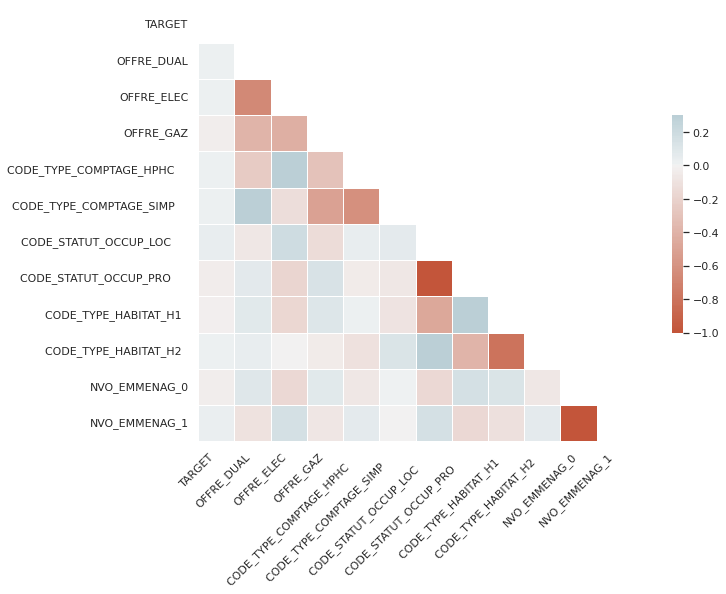

In [36]:
Score_AF_coor = pd.concat([df_raw.iloc[:,:],df_raw['TARGET']], axis = 1)

corr = df_raw.corr()
print (corr.loc['TARGET'])

mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

figure0 = plt.figure(figsize = (14, 8))

cmap = sns.diverging_palette(20, 220, sep=1, n=300)
#sns.palplot(sns.color_palette("RdBu_r", 7))
#sns.diverging_palette(240, 10, n=9)

sns.set(style="white")
sns.heatmap(corr, mask = mask, cmap=cmap, vmax=.3, center=0,
          square=True, linewidths=.5, cbar_kws={"shrink": .5}) #annot_kws={'size':20})
plt.gca().set_xticklabels(plt.gca().get_xticklabels(), rotation=45, horizontalalignment='right')
plt.show()

In [37]:
import imblearn as imb
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn import preprocessing

In [38]:
print(f"Unique ID_PERS  : {len(df_raw)}\nNB Churneurs : {df_raw.TARGET.sum()}")

Unique ID_PERS  : 5772160
NB Churneurs : 104386


In [39]:
X =  df_raw.loc[:, df_raw.columns != 'TARGET']
y =  df_raw['TARGET']

In [ ]:
print(X.columns)

Index(['MT_TOTL_FACT_12M', 'OFFRE_DUAL', 'OFFRE_ELEC', 'OFFRE_GAZ',
       'CODE_TYPE_COMPTAGE_3CAD    ', 'CODE_TYPE_COMPTAGE_HPHC    ',
       'CODE_TYPE_COMPTAGE_SIMP    ', 'CODE_STATUT_OCCUP_LOC     ',
       'CODE_STATUT_OCCUP_PRO     ', 'CODE_TYPE_HABITAT_H1  ',
       'CODE_TYPE_HABITAT_H2  ', 'NVO_EMMENAG_0', 'NVO_EMMENAG_1'],
      dtype='object')


In [40]:
# Create Validation Dataset
X_main, X_valid, y_main, y_valid = train_test_split(X, y, train_size = 0.85, stratify =y)

In [41]:
# Random UnderSampler
rus = imb.under_sampling.RandomUnderSampler(0.25)
X_sampled, y_sampled = rus.fit_resample(X_main,y_main)

/home/pj5720/.conda/envs/Edge/lib/python3.8/site-packages/imblearn/utils/_validation.py:587: FutureWarning: Pass sampling_strategy=0.25 as keyword args. From version 0.9 passing these as positional arguments will result in an error
  warnings.warn(


In [45]:
# Under Sampler on target
print(f"Resampled from {len(X_main)} to {len(X_sampled)}")
print(f"Target    from {sum(y_main)} to {sum(y_sampled)}")
X_train, X_test, y_train, y_test = train_test_split(X_sampled, y_sampled, train_size = 0.80, stratify=y_sampled)

Resampled from 4906336 to 443640
Target    from 88728 to 88728


In [43]:
y_sampled.value_counts()/len(y_sampled)

0    0.8
1    0.2
Name: TARGET, dtype: float64

In [128]:
#rus1 = imb.combine.SMOTETomek(0.10)
#pipe = imb.pipeline.make_pipeline( imb.over_sampling.SMOTE(0.25),imb.under_sampling.NearMiss(0.25))

/home/pj5720/.conda/envs/Edge/lib/python3.8/site-packages/imblearn/utils/_validation.py:587: FutureWarning: Pass sampling_strategy=0.1 as keyword args. From version 0.9 passing these as positional arguments will result in an error
  warnings.warn(


In [129]:
#rus1

SMOTETomek(sampling_strategy=0.1)

In [130]:
#X_clust , y_clust = rus1.fit_resample(X_main,y_main)

In [46]:
clf = LogisticRegression(max_iter=100000).fit(X_sampled, y_sampled)

In [67]:
clf.intercept_

array([-0.65708704])

In [68]:
clf.coef_

array([[ 0.16396899, -0.02215847, -0.79637081, -0.02363517, -0.22011998,
        -0.07246055, -0.5827885 ,  0.17682361,  0.18815365, -0.53241866,
        -0.12283039]])

In [74]:
X_sampled.columns

Index(['OFFRE_DUAL', 'OFFRE_ELEC', 'OFFRE_GAZ', 'CODE_TYPE_COMPTAGE_HPHC    ',
       'CODE_TYPE_COMPTAGE_SIMP    ', 'CODE_STATUT_OCCUP_LOC     ',
       'CODE_STATUT_OCCUP_PRO     ', 'CODE_TYPE_HABITAT_H1  ',
       'CODE_TYPE_HABITAT_H2  ', 'NVO_EMMENAG_0', 'NVO_EMMENAG_1'],
      dtype='object')

In [73]:
clf.coef_

array([[ 0.16396899, -0.02215847, -0.79637081, -0.02363517, -0.22011998,
        -0.07246055, -0.5827885 ,  0.17682361,  0.18815365, -0.53241866,
        -0.12283039]])

In [58]:
import sklearn.metrics as metrics
def regression_results(y_true, y_pred):

    # Regression metrics
    explained_variance=metrics.explained_variance_score(y_true, y_pred)
    mean_absolute_error=metrics.mean_absolute_error(y_true, y_pred) 
    mse=metrics.mean_squared_error(y_true, y_pred) 
    mean_squared_log_error=metrics.mean_squared_log_error(y_true, y_pred)
    median_absolute_error=metrics.median_absolute_error(y_true, y_pred)
    r2=metrics.r2_score(y_true, y_pred)

    print('explained_variance: ', round(explained_variance,4))    
    print('mean_squared_log_error: ', round(mean_squared_log_error,4))
    print('r2: ', round(r2,4))
    print('MAE: ', round(mean_absolute_error,4))
    print('MSE: ', round(mse,4))
    print('RMSE: ', round(np.sqrt(mse),4))

In [66]:
y_clf_pred_valid = clf.predict(X_valid_scaled)
y_clf_pred_valid_proba = clf.predict_proba(X_valid_scaled)

NameError: name 'X_valid_scaled' is not defined

In [ ]:
print( np.unique( y_clf_pred_valid) )   # le modèle prédit bien 2 classes

In [ ]:
#SCALING STEP
X_trained_scaled1 = preprocessing.scale(X_clust)
#X_test_scaled = preprocessing.scale(X_test)
X_valid_scaled1 =  preprocessing.scale(X_valid)

In [ ]:
clf_balanced = LogisticRegression(max_iter=100000, class_weight = 'balanced').fit(X_trained_scaled1, y_clust)

In [ ]:
y_clf_pred_valid2 = clf_balanced.predict(X_valid_scaled1)
y_clf_pred_valid_proba2 = clf_balanced.predict_proba(X_valid_scaled1)

In [ ]:
print( np.unique( y_clf_pred_valid2) )   # le modèle prédit bien 2 classes

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, roc_curve, balanced_accuracy_score
import scikitplot as skplt 

In [ ]:
def get_metrics(y_true, y_pred):
    metric_dict = classification_report(y_true, y_pred, output_dict=True)
    return pd.DataFrame.from_dict(metric_dict['1'], orient='index', dtype='float').T.apply(lambda x: round(x,5))

def get_deciles_repartition(y_true, y_pred_proba):
    NB_TARGET = y_true.sum()
    deciles_df = pd.DataFrame(data={'y_true' : y_true, 'scores_pred': y_pred_proba})
    deciles_df['decile'] = pd.qcut(deciles_df['scores_pred'], q=10 ,labels=np.arange(10, 0, -1))
    results_per_deciles = pd.crosstab(deciles_df['decile'],deciles_df['y_true'])
    results_per_deciles['Precision'] = results_per_deciles[1]*100 /(results_per_deciles[1]+results_per_deciles[0])
    results_per_deciles['Recall'] = results_per_deciles[1]*100 / NB_TARGET
    return results_per_deciles

In [ ]:
y_pred = clf.predict(X_valid)
balanced_accuracy_score(y_valid, y_clf_pred_valid)

In [ ]:
matrice_confusion = confusion_matrix(y_valid, y_clf_pred_valid)
print(matrice_confusion)

In [ ]:
print('Pourcentage de 1 bien prédit : {:.2f} %'.format(matrice_confusion[1][1]*100/(matrice_confusion[1][1]+matrice_confusion[1][0])))
print('Pourcentage de 0 bien prédit : {:.2f} %'.format(matrice_confusion[0][0]*100/(matrice_confusion[0][0]+matrice_confusion[0][1])))

In [ ]:
skplt.metrics.plot_cumulative_gain(y_valid, y_clf_pred_valid_proba,figsize= (15,15) )